In [1]:
from __future__ import print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import numpy as np
import importlib_resources
import pathlib
import shutil

# Load nuPyProp data & models modules
from nupyprop import data
from nupyprop import models

# Load astropy modules
from astropy.table import Table
from astropy.io import ascii

# Plotting modules
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns

sns.set_theme()
sns.set_context("paper")
sns.set_style("white", {"font.family": "STIXGeneral"})

# Plotting defaults
mpl.rcParams['xtick.labelsize'] = 26
mpl.rcParams['ytick.labelsize'] = 26
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['legend.fontsize'] = 23
plt.rcParams['legend.title_fontsize'] = 23
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['figure.titlesize'] = 30
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.linewidth'] = 2

# List of default charged lepton photonuclear energy loss models provided with nuPyProp

In [2]:
pn_models = ['allm', 'bb']

# See external photonuclear energy loss model files in the model directory

In [3]:
models_path = str(pathlib.Path(models.__file__).resolve().parent) # directory where the external model files exist

xc_files = glob.glob(models_path + '/xc_*.ecsv')
xc_files = [os.path.basename(file) for file in xc_files]
lep_xc_files = sorted([i for i in xc_files if ('tau' in i or 'muon' in i)])

ixc_files = glob.glob(models_path + '/ixc_*.ecsv')
ixc_files = [os.path.basename(file) for file in ixc_files]
lep_ixc_files = sorted([i for i in ixc_files if ('tau' in i or 'muon' in i)])

beta_files = glob.glob(models_path + '/beta_*.ecsv')
beta_files = [os.path.basename(file) for file in beta_files]
lep_beta_files = sorted([i for i in beta_files if ('tau' in i or 'muon' in i)])

for file in lep_xc_files + lep_ixc_files + beta_files:
    print(file)

xc_muon_pn_bdhm_rock.ecsv
xc_muon_pn_bdhm_water.ecsv
xc_muon_pn_ckmt_rock.ecsv
xc_muon_pn_ckmt_water.ecsv
xc_tau_pn_bdhm_rock.ecsv
xc_tau_pn_bdhm_water.ecsv
xc_tau_pn_ckmt_rock.ecsv
xc_tau_pn_ckmt_water.ecsv
ixc_muon_pn_bdhm_rock.ecsv
ixc_muon_pn_bdhm_water.ecsv
ixc_muon_pn_ckmt_rock.ecsv
ixc_muon_pn_ckmt_water.ecsv
ixc_tau_pn_bdhm_rock.ecsv
ixc_tau_pn_bdhm_water.ecsv
ixc_tau_pn_ckmt_rock.ecsv
ixc_tau_pn_ckmt_water.ecsv
beta_tau_pn_bdhm_water.ecsv
beta_tau_pn_ckmt_water.ecsv
beta_muon_pn_bdhm_water.ecsv
beta_muon_pn_bdhm_rock.ecsv
beta_muon_pn_ckmt_rock.ecsv
beta_tau_pn_bdhm_rock.ecsv
beta_muon_pn_ckmt_water.ecsv
beta_tau_pn_ckmt_rock.ecsv


## Since there are 2 external models: _BDHM & CKMT_ both for taus and muons and in both rock & water, there are a number of files generated. Let's lower the confusion by selecting only one model: _BDHM_ for _taus_ and printing out the list of all files required by this model

In [4]:
bdhm_xc = sorted([i for i in lep_xc_files if ('bdhm' in i and 'tau' in i)])
bdhm_ixc = sorted([i for i in lep_ixc_files if ('bdhm' in i and 'tau' in i)])
bdhm_beta = sorted([i for i in lep_beta_files if ('bdhm' in i and 'tau' in i)])

for file in bdhm_xc + bdhm_ixc + bdhm_beta:
    print(file)

xc_tau_pn_bdhm_rock.ecsv
xc_tau_pn_bdhm_water.ecsv
ixc_tau_pn_bdhm_rock.ecsv
ixc_tau_pn_bdhm_water.ecsv
beta_tau_pn_bdhm_rock.ecsv
beta_tau_pn_bdhm_water.ecsv


# Set global parameter values

In [5]:
part_type = 'tau' # we will look at the model for taus
model = 'ckmt' # 'bdhm' and 'ckmt' are two examples of external PN models provided in nuPyProp
material = 'rock' # we will look at the model for taus propagating in rock. Available materials are rock & water

# Write sample external photonuclear model files to current directory

In [6]:
model_xc = sorted([i for i in lep_xc_files if (model in i and part_type in i)])
model_ixc = sorted([i for i in lep_ixc_files if (model in i and part_type in i)])
model_beta = sorted([i for i in lep_beta_files if (model in i and part_type in i)])

for file in model_xc + model_ixc + model_beta:
    shutil.copy2(str(models_path) + "/" + str(file),'./')

## Note that if you want to create your own custom photonuclear model, you will have to create ecsv files (for cross-section values, cross-section CDF values, and the energy loss parameter beta individually for rock as well as water), which are astropy friendly (the details of which you can see in the following sections) and the files need to be present in the path specified in the variable _models_path_ 

# Now that the files are saved to your present working directory, let's try to read the files & plot them

## Reading a cross-section table

In [7]:
xc_table = Table.read('xc_%s_pn_%s_%s.ecsv' % (part_type,model,material), format='ascii.ecsv')

for key in xc_table.meta:
    print(key, ':', xc_table.meta[key],"\n")
    
print(xc_table)

Description : tau-nucleon cross-section values for ckmt in rock 

energy : tau energy, in GeV 

sigma_ckmt : cross-section for ckmt * N_A/A, in cm^2/g 

      energy           sigma_pn_ckmt     
------------------ ----------------------
               1.0                    0.0
1.2589254117941673                    0.0
1.5848931924611136                    0.0
1.9952623149688797                    0.0
  2.51188643150958                    0.0
3.1622776601683795                    0.0
 3.981071705534973                    0.0
 5.011872336272724                    0.0
 6.309573444801933                    0.0
 7.943282347242816 1.1238591708245858e-06
              10.0 1.4649772249738718e-06
12.589254117941675 1.8251642978382637e-06
               ...                    ...
 79432823472.42822  1.546449365212771e-05
    100000000000.0  1.588751849847759e-05
125892541179.41713 1.6324116323368948e-05
158489319246.11172 1.6774774436583115e-05
199526231496.88828 1.7240059318045438e-05
2511886

# Plotting the cross-section model values

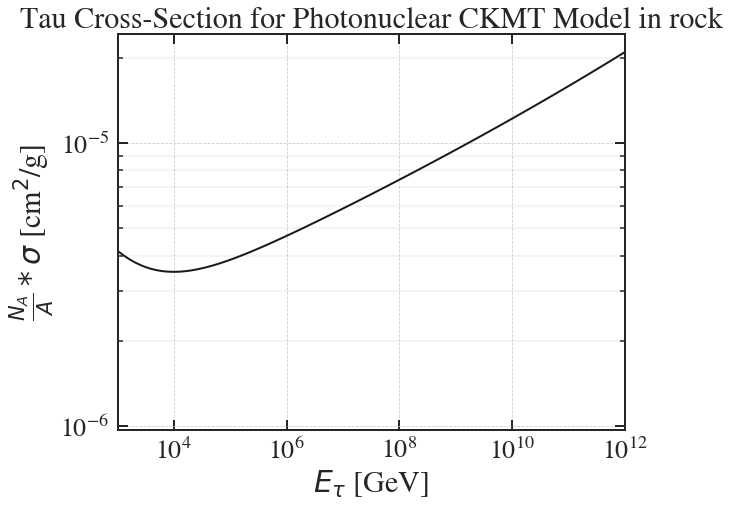

In [8]:
E_lep = data.E_lep # binned charged lepton (tau/muon) energy values, in GeV

sigma_pn = data.get_xc(part_type, model, material).T[-1] # 0th element is brem, 1st is pair-production & last is photonuclear

fig, axs = plt.subplots(1, figsize=(10/1.1, 8/1.1))

axs.loglog(E_lep, sigma_pn, color='k')

axs.grid(which='major', axis='both', linestyle='--')
axs.grid(which='minor', axis='both', linestyle=':', linewidth='0.2', color='black')
axs.xaxis.set_ticks_position('both')
axs.yaxis.set_ticks_position('both')
axs.set_xlim(1e3,1e12)
axs.set_ylabel(r'$\frac{N_A}{A}*\sigma$ [cm$^2$/g]')
axs.set_title('%s Cross-Section for Photonuclear %s Model in %s' % (str.capitalize(part_type),model.upper(),material))

if part_type=='tau':axs.set_xlabel(r'$E_{\tau}$ [GeV]')
else:axs.set_xlabel(r'$E_{\mu}$ [GeV]')
plt.show()

## Reading cross-section CDF table

In [9]:
ixc_table = Table.read('ixc_%s_pn_%s_%s.ecsv' % (part_type,model,material), format='ascii.ecsv')

for key in ixc_table.meta:
    print(key, ':', ixc_table.meta[key],"\n")
    
print(ixc_table)

Description : tau-nucleon cross-section CDF values for ckmt in rock 

energy : tau energy, in GeV 

y : Inelasticity, y = (E_init-E_final)/E_initial. 

cdf : Cross-section CDF value 

Note : The integrated cross-section CDF values should be integrated from y = 0, 10^(-0.1),...,10^(-3). This is a convention we chose to adopt 

     energy               y               cdf_pn_ckmt    
--------------- --------------------- -------------------
            1.0                   0.0                 0.0
            1.0    0.7943282347242815                 0.0
            1.0    0.6309573444801932                 0.0
            1.0    0.5011872336272722                 0.0
            1.0    0.3981071705534972                 0.0
            1.0   0.31622776601683794                 0.0
            1.0     0.251188643150958                 0.0
            1.0   0.19952623149688797                 0.0
            1.0   0.15848931924611137                 0.0
            1.0   0.12589254117941

## Reading beta (energy loss parameter) table

In [10]:
beta_table = Table.read('beta_%s_pn_%s_%s.ecsv' % (part_type,model,material), format='ascii.ecsv')

for key in beta_table.meta:
    print(key, ':', beta_table.meta[key],"\n")
    
print(beta_table)

Description : Model/parameterization dependent energy loss lookup table for tau in rock 

energy : tau energy, in GeV 

beta_pn_ckmt_cut : Photonuclear ckmt energy loss model beta value integrated from y_min to y_max=1e-3, in cm^2/g 

beta_pn_ckmt_total : Photonuclear ckmt energy loss model beta value integrated from y_min to y_max, in cm^2/g 

      energy          beta_pn_ckmt_cut      beta_pn_ckmt_total  
------------------ ---------------------- ----------------------
               1.0                    0.0                    0.0
1.2589254117941673                    0.0                    0.0
1.5848931924611136                    0.0                    0.0
1.9952623149688797                    0.0                    inf
  2.51188643150958                    0.0                    0.0
3.1622776601683795                    0.0 7.1259906165557436e-09
 3.981071705534973                    0.0  2.127190921737519e-08
 5.011872336272724                    0.0  3.555951097394866e-08
 6.

# Plotting beta for PN model

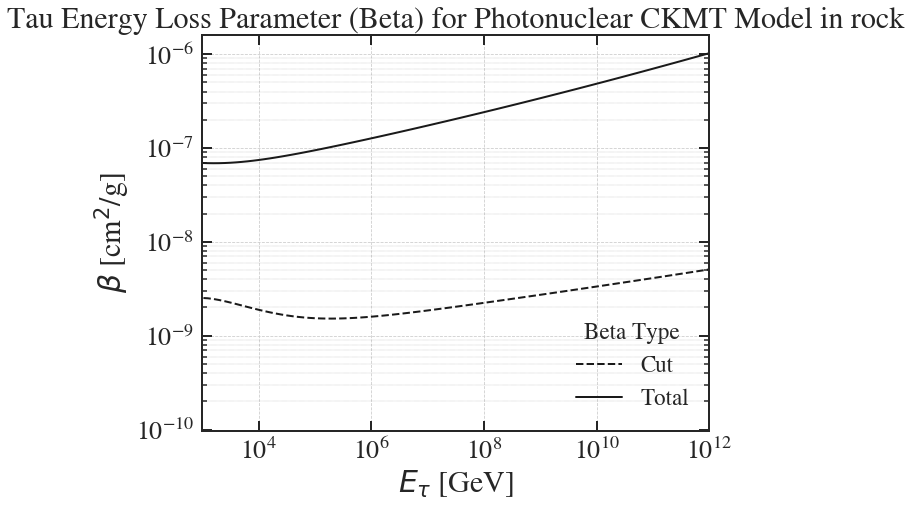

In [11]:
E_lep = data.E_lep # binned charged lepton (tau/muon) energy values, in GeV

beta_cut_pn = data.get_beta(part_type, model, material, 'cut').T[-1] # 0th element is brem, 1st is pair-production & last is photonuclear
beta_cut_total = data.get_beta(part_type, model, material, 'total').T[-1] # 0th element is brem, 1st is pair-production & last is photonuclear

fig, axs = plt.subplots(1, figsize=(10/1.1, 8/1.1))

axs.loglog(E_lep, beta_cut_pn, c='k', ls='--', label = 'Cut')
axs.loglog(E_lep, beta_cut_total, c='k', ls='-', label = 'Total')

axs.legend(loc='best',ncol=1, title = "Beta Type")
axs.grid(which='major', axis='both', linestyle='--')
axs.grid(which='minor', axis='both', linestyle=':', linewidth='0.2', color='black')
axs.xaxis.set_ticks_position('both')
axs.yaxis.set_ticks_position('both')
axs.set_xlim(1e3,1e12)
axs.set_ylabel(r'$\beta$ [cm$^2$/g]')
axs.set_title('%s Energy Loss Parameter (Beta) for Photonuclear %s Model in %s' % (str.capitalize(part_type),model.upper(),material))

if part_type=='tau':axs.set_xlabel(r'$E_{\tau}$ [GeV]')
else:axs.set_xlabel(r'$E_{\mu}$ [GeV]')
plt.show()

# Optional: Plot the charged lepton EM energy loss cross-section for all processes & models available in nuPyProp

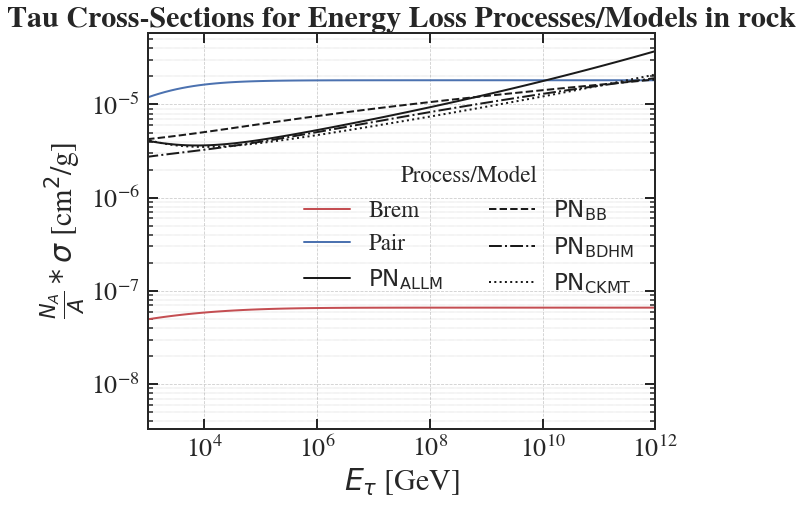

In [12]:
lep_models = ['brem', 'pair', 'allm', 'bb', 'bdhm', 'ckmt']
E_lep = data.E_lep # binned charged lepton (tau/muon) energy values, in GeV

colors = ['r','b']
color_map = cycle(colors)

lines = ["-", "--","-.",":",(0,(3,1,1,1))]
linecycler = cycle(lines)

fig, axs = plt.subplots(1, figsize=(10/1.1, 8/1.1))

for i in range(len(lep_models)):
    if i<2: # for sigma_brem & sigma_pair
        sigma = data.get_xc(part_type, model, material).T[i]
        axs.loglog(E_lep, sigma, color=next(color_map), lw = 2, label = "%s" % str.capitalize(lep_models[i]))
    else: # for sigma_pn
        color = next(color_map)
        sigma = data.get_xc(part_type, lep_models[i], material).T[-1]
        axs.loglog(E_lep, sigma, color='k', ls = next(linecycler), lw = 2, label = r"$\rm{PN_{%s}}$" % lep_models[i].upper())
    
axs.legend(loc='best',ncol=int(len(lep_models)/3), title = "Process/Model")
axs.grid(which='major', axis='both', linestyle='--')
axs.grid(which='minor', axis='both', linestyle=':', linewidth='0.2', color='black')
axs.xaxis.set_ticks_position('both')
axs.yaxis.set_ticks_position('both')
axs.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
axs.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= False)
axs.set_xlim(1e3,1e12)

if part_type == 'tau':axs.set_xlabel(r'$E_{\tau}$ [GeV]')
else:axs.set_xlabel(r'$E_{\mu}$ [GeV]')
    
axs.set_ylabel(r'$\frac{N_A}{A}*\sigma$ [cm$^2$/g]')
axs.set_title('%s Cross-Sections for Energy Loss Processes/Models in %s' % (str.capitalize(part_type),material),fontweight ="bold")
 
plt.show()

# Optional: Plot all charged lepton EM energy loss parameter (beta) for all processes & models available in nuPyProp

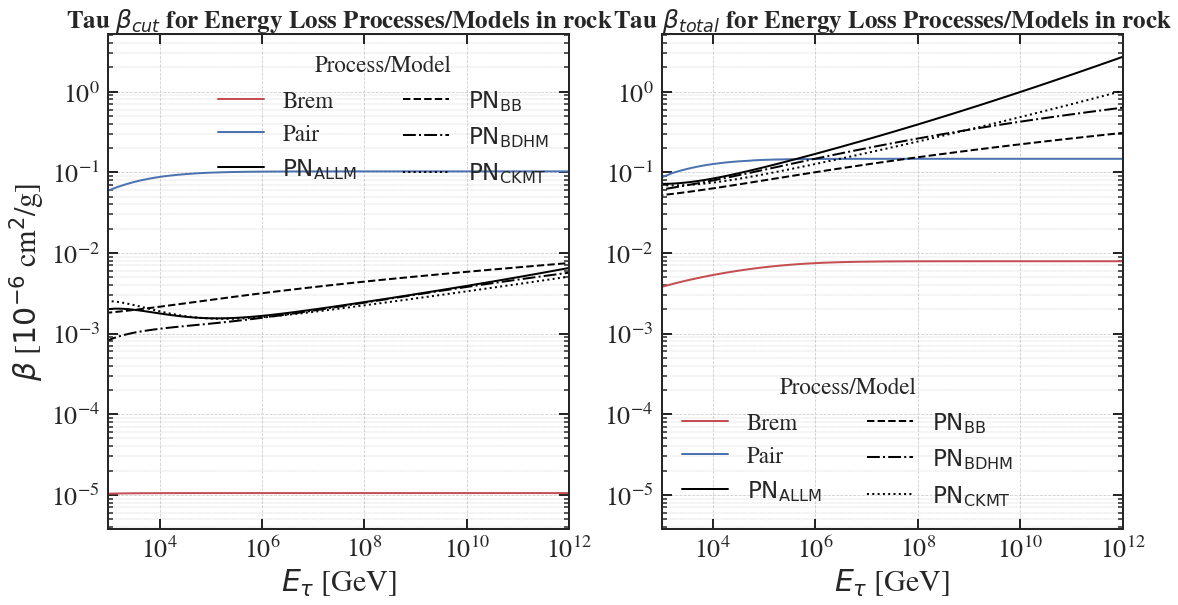

In [13]:
lep_models = ['brem', 'pair', 'allm', 'bb', 'bdhm', 'ckmt']
E_lep = data.E_lep # binned charged lepton (tau/muon) energy values, in GeV

colors = ['r','b']
color_map = cycle(colors)

lines = ["-", "--","-.",":",(0,(3,1,1,1))]
linecycler = cycle(lines)

fig, axs = plt.subplots(1,2, figsize=(20/1.1, 10/1.1), sharey=True)

for i in range(len(lep_models)):
    if i<2: # for sigma_brem & sigma_pair
        color = next(color_map)
        beta_cut = 1e6*data.get_beta(part_type, model, material, 'cut').T[i]
        beta_total = 1e6*data.get_beta(part_type, model, material, 'total').T[i]
        
        axs[0].loglog(E_lep, beta_cut, color=color, lw = 2, label = "%s" % str.capitalize(lep_models[i]))
        axs[1].loglog(E_lep, beta_total, color=color, lw = 2, label = "%s" % str.capitalize(lep_models[i]))
    else: # for sigma_pn
        ls = next(linecycler)
        beta_cut = 1e6*data.get_beta(part_type, lep_models[i], material, 'cut').T[-1]
        beta_total = 1e6*data.get_beta(part_type, lep_models[i], material, 'total').T[-1]
        
        axs[0].loglog(E_lep, beta_cut, color='black', ls = ls, lw = 2, label = r"$\rm{PN_{%s}}$" % lep_models[i].upper())
        axs[1].loglog(E_lep, beta_total, color='black', ls = ls, lw = 2, label = r"$\rm{PN_{%s}}$" % lep_models[i].upper())

for ax in axs:
    ax.legend(loc='best',ncol=int(len(lep_models)/3), title = "Process/Model")
    ax.grid(which='major', axis='both', linestyle='--')
    ax.grid(which='minor', axis='both', linestyle=':', linewidth='0.2', color='black')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='x', which='both', labelbottom = True, labeltop = False)
    ax.tick_params(axis='y', which='both', left = True, labelleft = True, labelright= False)
    ax.set_xlim(1e3,1e12)
    if part_type == 'tau':ax.set_xlabel(r'$E_{\tau}$ [GeV]')
    else:ax.set_xlabel(r'$E_{\mu}$ [GeV]')
    
axs[0].set_ylabel(r'$\beta$ [$10^{-6}$ cm$^2$/g]')
axs[0].set_title(r'%s $\beta_{cut}$ for Energy Loss Processes/Models in %s' % (str.capitalize(part_type),material),fontweight ="bold", fontsize=25)
axs[1].set_title(r'%s $\beta_{total}$ for Energy Loss Processes/Models in %s' % (str.capitalize(part_type),material),fontweight ="bold", fontsize=25)
 
plt.show()

# Optional: Remove ecsv files from current working directory

In [14]:
ecsv_files = glob.glob('*.ecsv')
for file in ecsv_files:
    os.remove(file)